# GAN study
<hr style='height:5px'>
kwanki.ahn<br>
2019/05/29<br>
ref : https://tykimos.github.io/2018/10/10/Understanding_Generative_Adversarial_Nets/<hr style='height:5px'>

In [1]:
!sudo pip install keras==2.0.6

In [2]:
!sudo pip install tensorflow

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [2]:
# Keras 가 Tensorflow 를 벡엔드로 사용할 수 있도록 설정합니다.
os.environ["KERAS_BACKEND"] = "tensorflow"

# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

In [3]:
def load_minst_data():
    # 데이터를 로드합니다.
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # 데이터를 -1 ~ 1 사이 값으로 normalize 합니다.
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    # x_train 의 shape 를 (60000, 28, 28) 에서 (60000, 784) 로 바꿉니다.
    # 따라서 우리는 한 row 당 784 columns 을 가지게 됩니다.
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


In [4]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


In [5]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # 우리는 Generator와 Discriminator를 동시에 학습시키고 싶을 때 trainable을 False로 설정합니다.
    discriminator.trainable = False

    # GAN 입력 (노이즈)은 위에서 100 차원으로 설정했습니다.
    gan_input = Input(shape=(random_dim,))

    # Generator의 결과는 이미지 입니다.
    x = generator(gan_input)

    # Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률입니다.
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


In [6]:
# 생성된 MNIST 이미지를 보여주는 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


In [8]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져옵니다.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = x_train.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batch_count)):
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # MNIST 이미지를 생성합니다.
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            # Discriminator를 학습시킵니다.
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Generator를 학습시킵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


  0%|          | 1/468 [00:00<00:57,  8.13it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<00:57,  8.16it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<00:55,  8.47it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<01:27,  5.35it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/468 [00:00<01:28,  5.28it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:58,  8.00it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/468 [00:00<01:01,  7.58it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<00:56,  8.20it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:56<00:00,  8.26it/s]


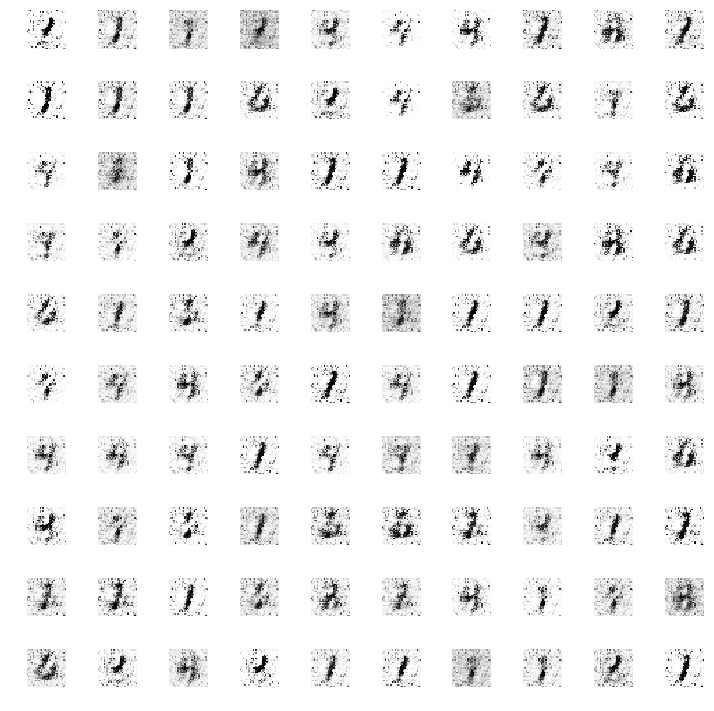

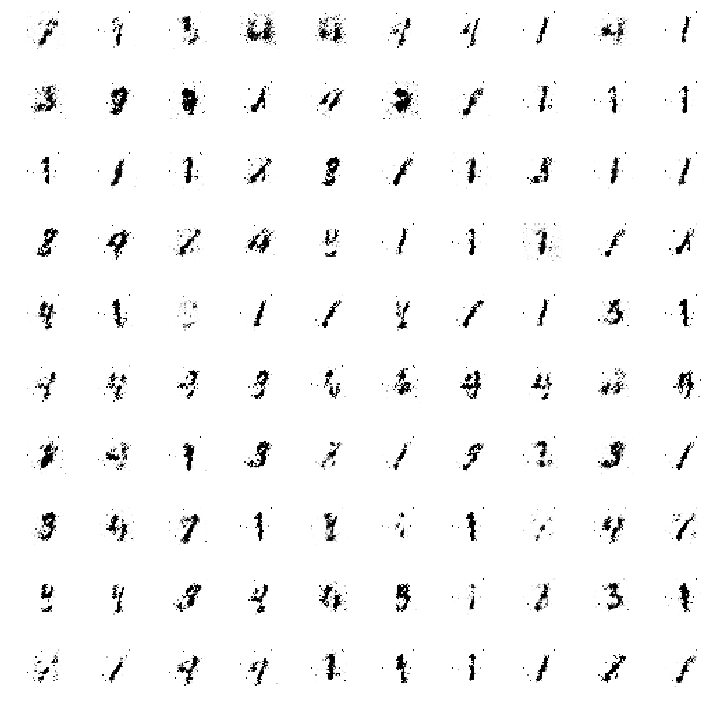

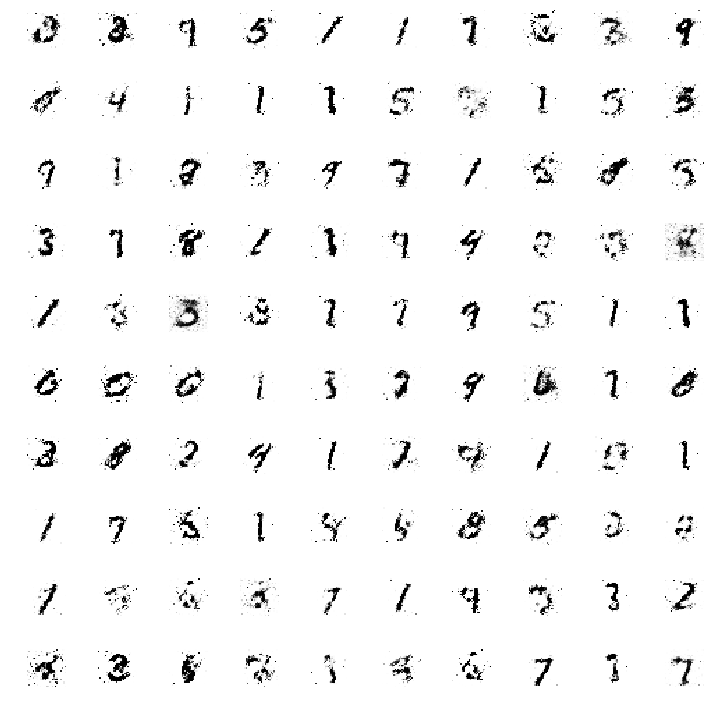

In [9]:
train(10, 128)